<a href="https://www.kaggle.com/code/maxabdulkerimov/car-price-prediction?scriptVersionId=138014837" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('../input/cardataset/data.csv')

In [4]:
len(df)

11914

In [5]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## Pre-processing the data

In [6]:
# removing spaces and upper case letters from column titles
df.columns = df.columns.str.lower().str.replace(' ','_')

# removing spaces and upper case letters from non-number columns
string_columns = list(df.dtypes[df.dtypes == 'object'].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ','_')

In [7]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


### EDA


In [8]:
np.max(df.msrp)
log_price = np.log1p(df.msrp) # log transformation

<Axes: xlabel='msrp', ylabel='Count'>

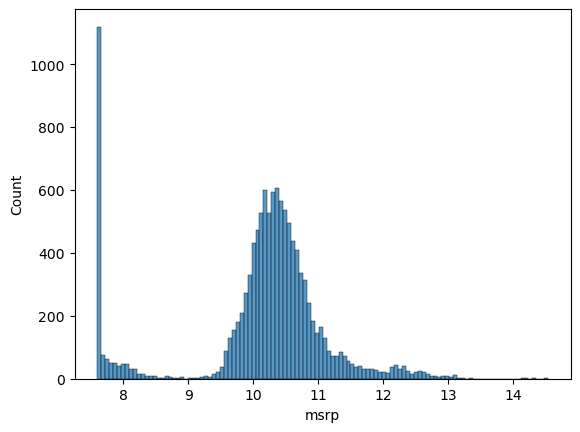

In [9]:
sns.histplot(log_price)

#### Checking for missing values in the data


In [10]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

#### Splitting the data up

In [11]:
n = len(df)
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n-(n_val + n_test)

idx = np.arange(n)
np.random.seed(2) # makes sure results are reproducible
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [12]:
y_train = np.log1p(df_train.msrp)
y_val = np.log1p(df_val.msrp)
y_test = np.log1p(df_test.msrp)

In [13]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## Making the model


In [14]:
def linear_reg(X, y, a=0.0):
    # dummy columns
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones,X]) # inserts ones as first column
    
    # normal equation (closed form solutions)
    XTX = X.T.dot(X)
    # regularization to fix numerical instability (make matrix invertible)
    reg = a * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX + reg)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### Feature Engineering


In [15]:
print(df['engine_fuel_type'].value_counts())

regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: engine_fuel_type, dtype: int64


In [16]:
print(df['transmission_type'].value_counts())

automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: transmission_type, dtype: int64


In [17]:
print(df['driven_wheels'].value_counts())

front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: driven_wheels, dtype: int64


In [18]:
print(df['market_category'].value_counts())

crossover                                          1110
flex_fuel                                           872
luxury                                              855
luxury,performance                                  673
hatchback                                           641
                                                   ... 
crossover,exotic,luxury,performance                   1
exotic,luxury,high-performance,hybrid                 1
crossover,exotic,luxury,high-performance              1
flex_fuel,factory_tuner,luxury,high-performance       1
performance,hybrid                                    1
Name: market_category, Length: 71, dtype: int64


In [19]:
print(df['vehicle_size'].value_counts())

compact    4764
midsize    4373
large      2777
Name: vehicle_size, dtype: int64


In [20]:
print(df['number_of_doors'].value_counts())

4.0    8353
2.0    3160
3.0     395
Name: number_of_doors, dtype: int64


In [21]:
print(df['make'].value_counts())

chevrolet        1123
ford              881
volkswagen        809
toyota            746
dodge             626
nissan            558
gmc               515
honda             449
mazda             423
cadillac          397
mercedes-benz     353
suzuki            351
bmw               334
infiniti          330
audi              328
hyundai           303
volvo             281
subaru            256
acura             252
kia               231
mitsubishi        213
lexus             202
buick             196
chrysler          187
pontiac           186
lincoln           164
oldsmobile        150
land_rover        143
porsche           136
saab              111
aston_martin       93
plymouth           82
bentley            74
ferrari            69
fiat               62
scion              60
maserati           58
lamborghini        52
rolls-royce        31
lotus              29
tesla              18
hummer             17
maybach            16
alfa_romeo          5
mclaren             5
spyker    

In [22]:
def binary_encoding(dfc, feature_name, freq):
    # freq refers to the number of top most frequent variables selected (e.g. top 5)
    # dfc is the dataframe passed that needs to be encoded (e.g. df_train)
    features = []
    for v in df[feature_name].value_counts()[:freq].index.tolist():
        feature = f"is_{feature_name}_{v}"
        dfc[feature] = (dfc[feature_name] == v).astype(int)
        features.append(feature)

    return dfc, features

## Training Model


In [23]:
# selecting features for baseline model
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
addi = ['make', 'engine_fuel_type', 'transmission_type', 'driven_wheels', 'market_category', 'vehicle_size', 'vehicle_style']
    
def prep_X(df):
    df = df.copy()
    features = base.copy()
    
    for f in addi:
        df, ft = binary_encoding(df, f, 5)
        features.extend(ft)

    # Adding one-hot encoding, age of car
    df['age'] = 2017 - df.year # latest year is 2017
    features.append('age')
    
    # Adding features as binary encodings
    for v in [2,3,4]: # all possible door options
        feature = 'num_doors_%s'%v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X
    

In [24]:
X_train = prep_X(df_train)
w_0, w = linear_reg(X_train, y_train, 0.01)
y_pred = w_0 + X_train.dot(w)

## Evaluating Model


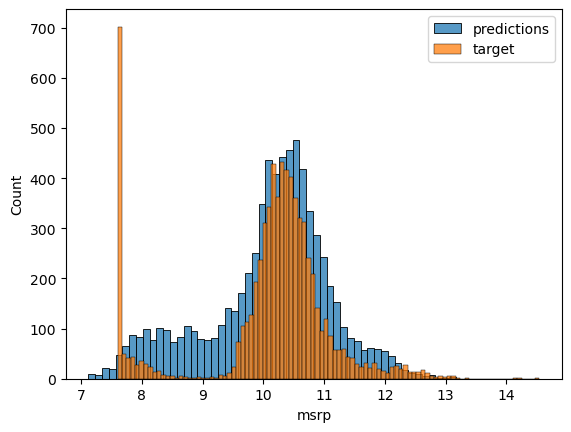

In [25]:
sns.histplot(y_pred, label='predictions')
sns.histplot(y_train, label='target')
plt.legend()

### Root Mean Squared Error (RMSE)

In [26]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

### Validating Model


In [27]:
X_train = prep_X(df_train)
w_0, w = linear_reg(X_train, y_train, 0.01)
y_pred = w_0 + X_train.dot(w)
print(f"training: {rmse(y_train, y_pred)}")

training: 0.46020995202173626


In [28]:
X_val = prep_X(df_val)
y_pred = w_0 + X_val.dot(w)
print(f"validation: {rmse(y_val, y_pred)}")

validation: 0.4565219901133827


### Testing Model

In [29]:
X_test = prep_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

test: 0.452233225445025


## Using the Model

In [30]:
description = {
    'city_mpg': 18,
    'driven_wheels': 'all_wheel_drive',
    'engine_cylinders': 6.0,
    'engine_fuel_type': 'regular_unleaded',
    'engine_hp': 268.0,
    'highway_mpg': 25,
    'make': 'toyota',
    'market_category': 'crossover,performance',
    'model': 'venza',
    'number_of_doors': 4.0,
    'popularity': 2031,
    'transmission_type': 'automatic',
    'vehicle_size': 'midsize',
    'vehicle_style': 'wagon', 
    'year': 2013
}

In [31]:
df_inf = pd.DataFrame([description])
X_inf = prep_X(df_inf)
y_inf = w_0 + X_inf.dot(w)

In [32]:
prediction = np.expm1(y_inf)
print(f'Predicted Price: ${prediction[0]:.2f}')

Predicted Price: $28932.02
